### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import json
import pickle
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Read the image
img_arr = cv2.imread('/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/CK+48/angry/S010_004_00000017.png')
img_arr.shape

(48, 48, 3)

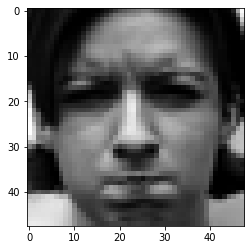

In [4]:
plt.imshow(img_arr)
plt.show()

In [5]:
gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
gray.shape

(48, 48)

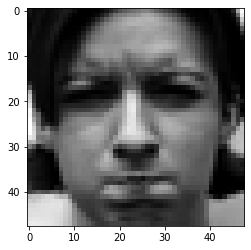

In [6]:
plt.imshow(gray, cmap='gray')
plt.show()

In [7]:
### Training dataset
datadirectory = '/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/CK+48/'

In [8]:
img_dirs = []
for entry in os.scandir(datadirectory):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [9]:
img_dirs

['/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/CK+48/disgust',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/CK+48/fear',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/CK+48/sad',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/CK+48/happy',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/CK+48/surprise',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/CK+48/neutral',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/CK+48/angry']

In [10]:
emotions = []
for img_dir in img_dirs:
    emotion_name = img_dir.split('/')[-1]
    emotions.append(emotion_name)

In [11]:
emotions

['disgust', 'fear', 'sad', 'happy', 'surprise', 'neutral', 'angry']

### Read all the images and converting them into array

In [12]:
training_data = []

for emotion in emotions:
    path = os.path.join(datadirectory, emotion)
    label = emotions.index(emotion)
    print('{} --> {}'.format(emotion, label))
    for img in os.listdir(path):
        imgpath = os.path.join(path, img)
        emotion_img = cv2.imread(imgpath)
        emotion_img = cv2.cvtColor(emotion_img, cv2.COLOR_BGR2GRAY)
        try:
            emotion_img = cv2.resize(emotion_img, (48, 48))
            image = np.array(emotion_img).flatten()        
            training_data.append([image, label])
        except Exception as e:
            pass

disgust --> 0
fear --> 1
sad --> 2
happy --> 3
surprise --> 4
neutral --> 5
angry --> 6


In [13]:
print(len(training_data))

1127


In [14]:
import random 
random.shuffle(training_data)

In [15]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

### Splitting the data into training and test set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Training the model with different machine learning models

In [17]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [19]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.965791,"{'svc__C': 100, 'svc__kernel': 'rbf'}"
1,random_forest,0.885802,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.963243,{'logisticregression__C': 10}


In [20]:
best_estimators

{'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=10, solver='liblinear'))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=100, gamma='auto', probability=True))])}

In [21]:
best_estimators['svm'].score(X_test,y_test)

0.9823008849557522

In [22]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.9793510324483776

In [23]:
best_estimators['random_forest'].score(X_test,y_test)

0.8820058997050148

In [24]:
best_clf_svm = best_estimators['svm']

In [25]:
best_clf_svm

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100, gamma='auto', probability=True))])

In [26]:
cm = confusion_matrix(y_test, best_clf_svm.predict(X_test))
cm

array([[57,  2,  0,  0,  0,  0,  0],
       [ 0, 21,  0,  1,  0,  0,  0],
       [ 1,  0, 22,  0,  0,  0,  0],
       [ 0,  0,  0, 68,  0,  0,  0],
       [ 0,  0,  0,  0, 65,  0,  0],
       [ 0,  0,  1,  0,  0, 59,  1],
       [ 0,  0,  0,  0,  0,  0, 41]])

Text(69.0, 0.5, 'Truth')

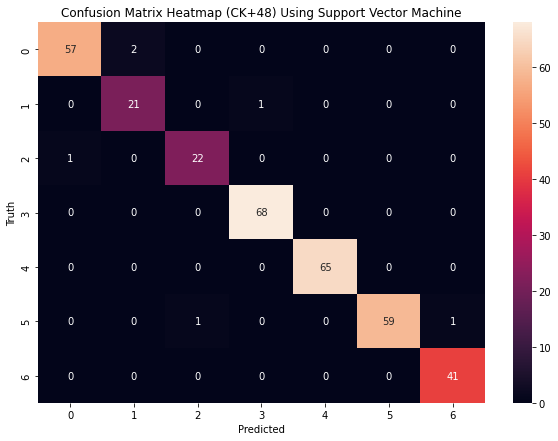

In [27]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix Heatmap (CK+48) Using Support Vector Machine')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [28]:
cr_svm = classification_report(y_test, best_clf_svm.predict(X_test))
print(cr_svm)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        59
           1       0.91      0.95      0.93        22
           2       0.96      0.96      0.96        23
           3       0.99      1.00      0.99        68
           4       1.00      1.00      1.00        65
           5       1.00      0.97      0.98        61
           6       0.98      1.00      0.99        41

    accuracy                           0.98       339
   macro avg       0.97      0.98      0.98       339
weighted avg       0.98      0.98      0.98       339



In [29]:
best_clf_logistic_reg = best_estimators['logistic_regression']

In [30]:
best_clf_logistic_reg

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=10, solver='liblinear'))])

In [31]:
cm_logistic_reg = confusion_matrix(y_test, best_clf_logistic_reg.predict(X_test))
cm_logistic_reg

array([[59,  0,  0,  0,  0,  0,  0],
       [ 0, 21,  0,  1,  0,  0,  0],
       [ 0,  0, 23,  0,  0,  0,  0],
       [ 0,  0,  0, 68,  0,  0,  0],
       [ 0,  0,  0,  0, 65,  0,  0],
       [ 1,  0,  0,  1,  1, 55,  3],
       [ 0,  0,  0,  0,  0,  0, 41]])

Text(69.0, 0.5, 'Truth')

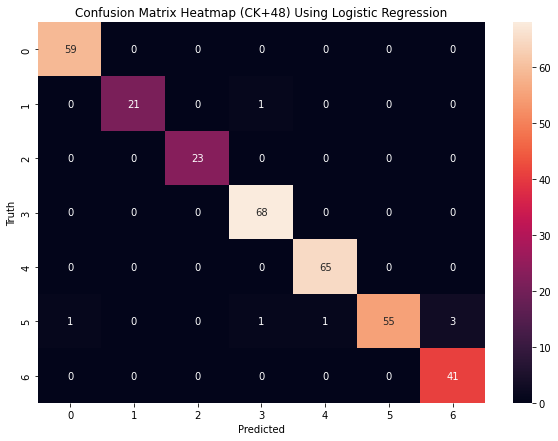

In [32]:
plt.figure(figsize = (10,7))
sns.heatmap(cm_logistic_reg, annot=True)
plt.title('Confusion Matrix Heatmap (CK+48) Using Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [33]:
cr_logistic_reg = classification_report(y_test, best_clf_logistic_reg.predict(X_test))
print(cr_logistic_reg)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       1.00      0.95      0.98        22
           2       1.00      1.00      1.00        23
           3       0.97      1.00      0.99        68
           4       0.98      1.00      0.99        65
           5       1.00      0.90      0.95        61
           6       0.93      1.00      0.96        41

    accuracy                           0.98       339
   macro avg       0.98      0.98      0.98       339
weighted avg       0.98      0.98      0.98       339



In [34]:
best_clf_random_forest = best_estimators['random_forest']

In [35]:
best_clf_random_forest

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=10))])

In [36]:
cm_random_forest = confusion_matrix(y_test, best_clf_random_forest.predict(X_test))
cm_random_forest

array([[54,  0,  0,  3,  0,  0,  2],
       [ 1, 17,  3,  0,  0,  0,  1],
       [ 0,  0, 23,  0,  0,  0,  0],
       [ 3,  0,  2, 61,  1,  0,  1],
       [ 0,  1,  0,  0, 64,  0,  0],
       [ 7,  2,  1,  0,  3, 45,  3],
       [ 1,  1,  1,  0,  0,  3, 35]])

Text(69.0, 0.5, 'Truth')

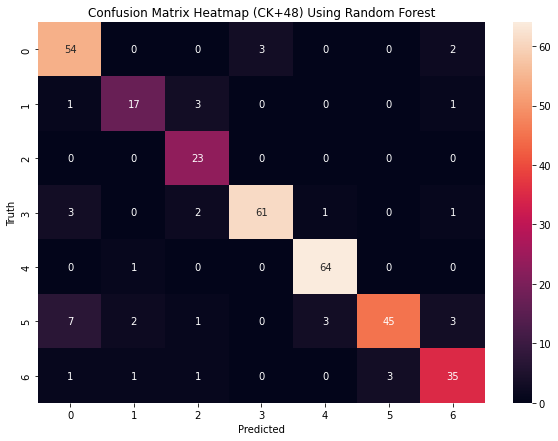

In [37]:
plt.figure(figsize = (10,7))
sns.heatmap(cm_random_forest, annot=True)
plt.title('Confusion Matrix Heatmap (CK+48) Using Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
cr_random_forest = classification_report(y_test, best_clf_random_forest.predict(X_test))
print(cr_random_forest)

              precision    recall  f1-score   support

           0       0.82      0.92      0.86        59
           1       0.81      0.77      0.79        22
           2       0.77      1.00      0.87        23
           3       0.95      0.90      0.92        68
           4       0.94      0.98      0.96        65
           5       0.94      0.74      0.83        61
           6       0.83      0.85      0.84        41

    accuracy                           0.88       339
   macro avg       0.87      0.88      0.87       339
weighted avg       0.89      0.88      0.88       339



In [39]:
emotion_dict = {
    'disgust': 0,
    'fear': 1,
    'sad': 2,
    'happy': 3,
    'surprise': 4,
    'neutral': 5,
    'angry': 6
}

In [40]:
with open("/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/Models/emotion_dictionary-CK+48.json", "w") as f:
  f.write(json.dumps(emotion_dict))

In [41]:
with open("/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/Models/model_svm-CK+48.pkl", "wb") as f:
  pickle.dump(best_clf_svm, f)

In [42]:
with open("/content/drive/MyDrive/Major Project/test-emotion-detection/CK+48 wala/Models/model_logistic_regression-CK+48.pkl", "wb") as f:
  pickle.dump(best_clf_logistic_reg, f)